In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
from random import seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [3]:
student_data = pd.read_csv('metadata_primaryschool.csv',names=['ID', 'Class', 'Sex'])
contact_data = pd.read_csv('primaryschool.csv',delimiter='\t',names=['Time', 'ID 1', 'ID 2', 'Class 1', 'Class 2'])

In [4]:
student_data

,ID,Class,Sex
0,1426,5B,M
1,1427,5B,F
2,1428,5B,M
3,1429,5B,F
4,1430,5B,M
...,...,...,...
237,1916,2A,M
238,1917,2A,F
239,1919,2A,M
240,1920,1B,F


In [5]:
contact_data

,Time,ID 1,ID 2,Class 1,Class 2
0,31220,1558,1567,3B,3B
1,31220,1560,1570,3B,3B
2,31220,1567,1574,3B,3B
3,31220,1632,1818,4B,4B
4,31220,1632,1866,4B,4B
...,...,...,...,...,...
125768,148120,1752,1783,1A,1A
125769,148120,1752,1789,1A,1A
125770,148120,1775,1798,1A,1A
125771,148120,1783,1796,1A,1A


In [6]:
contact_data['Time'] = ((contact_data['Time'] - 31220)//2) + 10
contact_data

,Time,ID 1,ID 2,Class 1,Class 2
0,10,1558,1567,3B,3B
1,10,1560,1570,3B,3B
2,10,1567,1574,3B,3B
3,10,1632,1818,4B,4B
4,10,1632,1866,4B,4B
...,...,...,...,...,...
125768,58460,1752,1783,1A,1A
125769,58460,1752,1789,1A,1A
125770,58460,1775,1798,1A,1A
125771,58460,1783,1796,1A,1A


In [7]:
N = student_data.shape[0]

start_id = student_data.ID[0]
end_id = student_data.ID[N-1]
compartment = ['S' for i in range(end_id-start_id+1)]


In [8]:
student_data

,ID,Class,Sex
0,1426,5B,M
1,1427,5B,F
2,1428,5B,M
3,1429,5B,F
4,1430,5B,M
...,...,...,...
237,1916,2A,M
238,1917,2A,F
239,1919,2A,M
240,1920,1B,F


In [9]:
class SIRModel:

  def __init__(self, beta, gamma, start_infected):
    self.beta=beta
    self.gamma=gamma
    self.start_infected=start_infected

  def introduce_infection(self, start_infected):
    for i in range(start_infected):
      infected=random.choice(student_data['ID'])
      compartment[infected-start_id] = 'I'

  def recovery(self,R,I):
    recoveries=R
    infected=I
    for id in student_data['ID']:
      if compartment[id-start_id] == 'I':
        if random.random()< self.gamma:
          compartment[id-start_id] == 'R'
          recoveries+=1
          infected-=1
    return recoveries,infected

  def simulate(self):
    self.introduce_infection(self.start_infected)
    R=0
    I=self.start_infected
    S=N-I-R
    X = [S]
    Y = [I]
    Z = [R]
    Time = [0]
    i = 0
    while i < contact_data.shape[0]:
      t = Time[-1]+10
      while i < contact_data.shape[0] and contact_data['Time'][i] == t:
        id1=contact_data['ID 1'][i]
        id2=contact_data['ID 2'][i]
        if compartment[id1-start_id]=='S' and compartment[id2-start_id]=='I':
          if random.random() < self.beta:
            S-=1
            I+=1
            compartment[id1-start_id]='I'
        elif compartment[id2-start_id]=='S' and compartment[id1-start_id]=='I':
          if random.random() < self.beta:
            S-=1
            I+=1
            compartment[id2-start_id]='I'
        i = i + 1
      
      R,I = self.recovery(R,I)
      
      X.append(S)
      Y.append(I)
      Z.append(R)
      Time.append(t)


    return X, Y, Z, Time




In [10]:
model = SIRModel(
    beta=1/200,gamma=1/5000,start_infected=15
)

In [11]:
X, Y, Z, t = model.simulate()

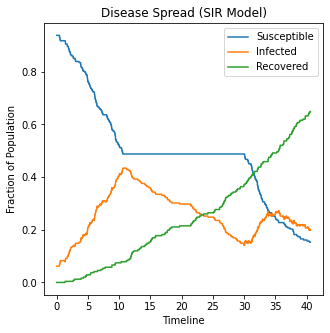

In [12]:
Rate_S = np.array(X)/N
Rate_I = np.array(Y)/N
Rate_R = np.array(Z)/N
time = np.array(t) / (60 * 24)

plt.figure(figsize=(5, 5))
plt.plot(time, Rate_S, label='Susceptible')
plt.plot(time, Rate_I, label='Infected')
plt.plot(time, Rate_R, label='Recovered')
plt.legend()
plt.title('Disease Spread (SIR Model)')
plt.xlabel('Timeline')
plt.ylabel('Fraction of Population')
plt.show()